# Activate a GPU accelerator before running!

Based on [U-Net based Autoencoder for Denoising (MNIST)](https://www.kaggle.com/code/shuvostp/u-net-based-autoencoder-for-denoising-mnist).

In [1]:
# Import the libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Load the dataset and split it in two sets: the train dataset and the test dataset.
# The train dataset is used to train the model (in our case an CNN),
# and the test dataset is used to see if the ANN is working properly (learning)
# with samples that have not been used for training the model.

(X_train, _), (X_test, _) = mnist.load_data()

# In ML, the "X"-part of a dataset usually contain the inputs to the model, and
# the Y-part the desired output, which the model must learn to predict.
# In the MNIST dataset there are not noisy images (all of them are clean images).
# For this reason the "Y"-part is ignored (we use a variable with the name "_").

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
np.set_printoptions(linewidth=150)
print(X_train.shape)
print(X_test.shape)
print(f"The maximum pixel value: {X_train[0].max()}")
print(f"The minimum pixel value: {X_train[0].min()}")
print(X_train[2001])

(60000, 28, 28)
(10000, 28, 28)
The maximum pixel value: 255
The minimum pixel value: 0
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   2  18  18 145 255 254 249 136 115   5   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  93 163 253 253 253 253 253 253 253 253  70   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 152 250 253 253 253 253 253 253 253 253 253 164  11   0   0  

In [4]:
# Scale the pixel values between [0, 1].

X_train = X_train/255.0
X_test = X_test/255.0

# In Tensorflow/Keras (and in most of the ML libraries), the sample values must be
# floating point numbers between 0.0 and 1.0.

In [5]:
# Re-shape the dataset.

#X_train = X_train.reshape(-1,28,28,1)
#X_test = X_test.reshape(-1,28,28,1)

# Tensorflow/Keras (as in most of the ML libs) works with tensors.
# By definition, a tensor have 4 dimensions.

In [6]:
print(X_train.shape)
print(X_test.shape)
print(f"The maximum pixel value: {X_train[0].max()}")
print(f"The minimum pixel value: {X_train[0].min()}")
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
The maximum pixel value: 1.0
The minimum pixel value: 0.0


In [7]:
# Y-part of the dataset.

# Add Gaussian noise.
noise_factor = .8
Y_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

# Pixel values must fit in [0.0, 1.0].
Y_train = np.clip(Y_train, 0.0, 1.0)

# The Y-part is equal to a noisy version of the X-part.

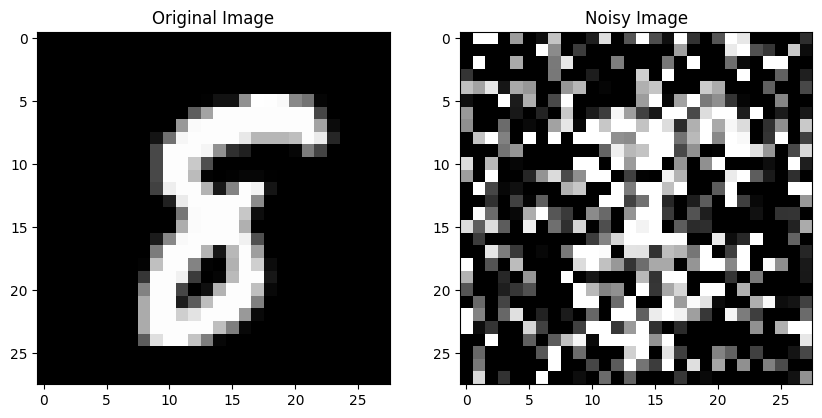

In [8]:
n=2001
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].imshow(X_train[n], cmap='gray')
ax[1].imshow(Y_train[n], cmap='gray')
ax[0].set_title("Original Image")
ax[1].set_title("Noisy Image")
plt.show()

In [9]:
# Define the model.

# An U-Net is an auto-encoder with skip connections. In an autoencoder there are
# two main parts: (1) the encoder (compressive) part, where the layers decrease
# in size but increase in channels, and the decoder (expansive) parte, where
# the layers increase in size but decrease in channels.

# Input shape. Samples (images) have 28x28 gray-scale pixels.
input_shape = (28, 28, 1)

# Define a tensor for representing a sample.
input = Input(input_shape)

# Begin of the encoder definition (the sequence of layers).
conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input)
# The conv1 layer have 32 channels (generate 32 feature maps).
# Because "padding='same'", the resolution of each feature map is 28x28.
# The 2D kernels have 3x3 coefficients (every neuron of the layer N+1 is
# connected with 9 neurons of the layer N).
# If the output of the neuron where negative (it could happen), the output is
# set to zero.
# The content of the input (first layer) is a sample.

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
# When the parameters are provided in order, we don't need to name them.

# Reduce by 2 the resolution (neuron outputs) of the feature map.
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
# By default, strides=pool_size, and therefore, the 2x2 windows do not overlap.

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pool2 = MaxPooling2D((2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
# End of the encoder definition.

# Define the decoder part of the networkup
up1 = UpSampling2D((2, 2))(conv6)
up1 = Conv2D(64, (2, 2), activation='relu', padding='same')(up1)
merge1 = concatenate([conv4, up1], axis=3)

conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

up2 = UpSampling2D((2, 2))(conv8)
conv9 = Conv2D(32, (2, 2), activation='relu', padding='same')(up2)
merge2 = concatenate([conv1, conv9], axis=3)

conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)

# Define the output layer of the network
output = Conv2D(1, (1, 1), activation='sigmoid')(conv11)

# Define the model
model = Model(inputs=[input], outputs=[output])

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 128) │    147,584 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 14, 14,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │     32,832 │ up_sampling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 28, 28,    │          0 │ conv2d_8[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │      8,224 │ up_sampling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 64)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 465,953 (1.78 MB)

 Trainable params: 465,953 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

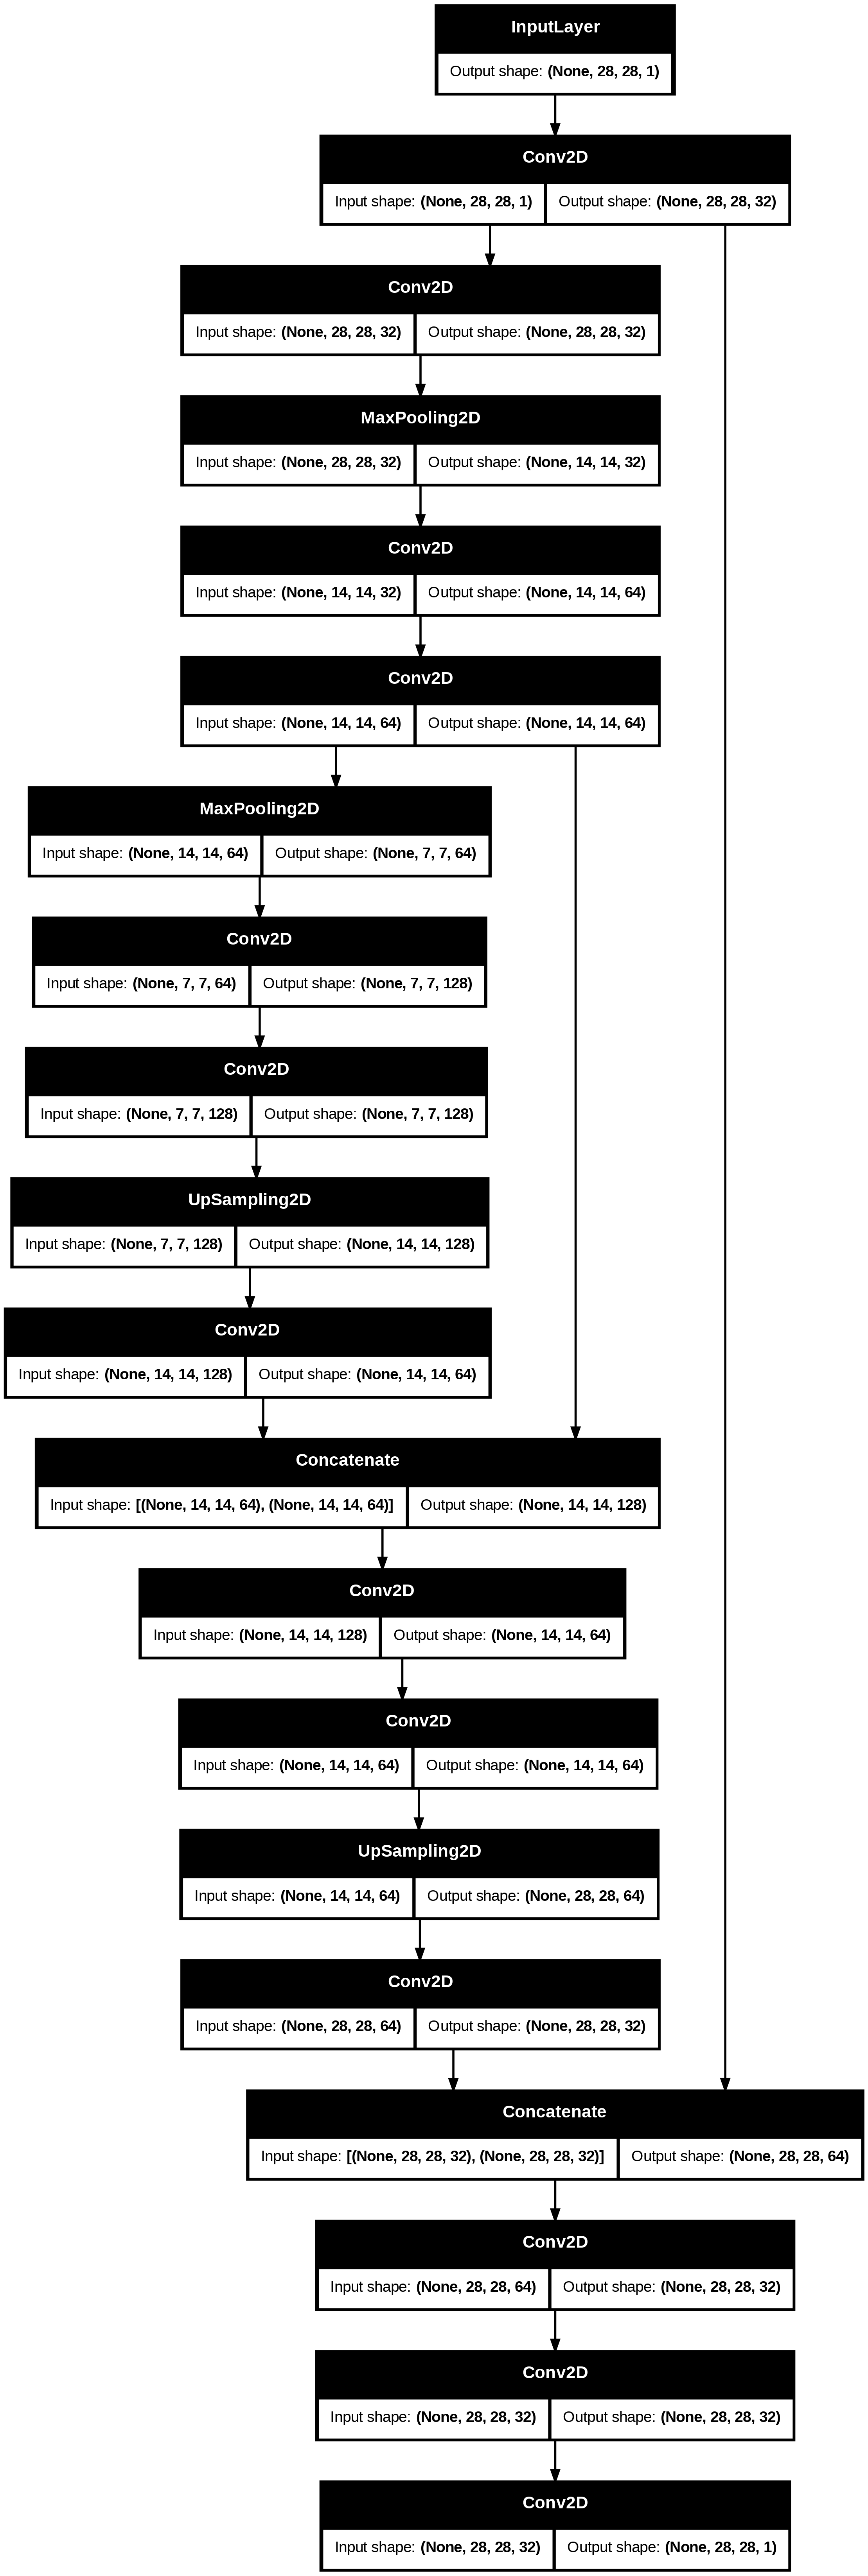

In [12]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [13]:
number_of_epochs = 2
history = model.fit(Y_train, X_train, epochs=number_of_epochs, verbose=1, batch_size=128, shuffle=True)

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7958 - loss: 0.2374


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8187 - loss: 0.1027


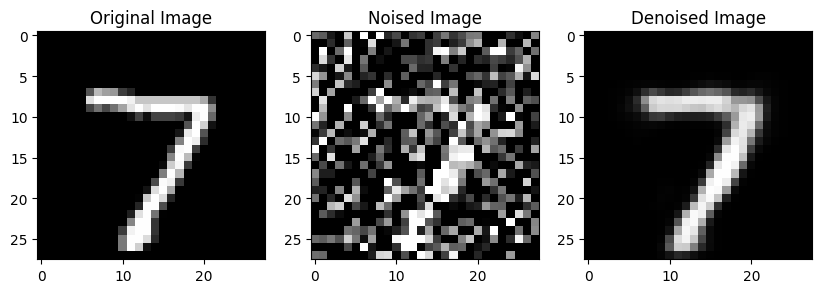

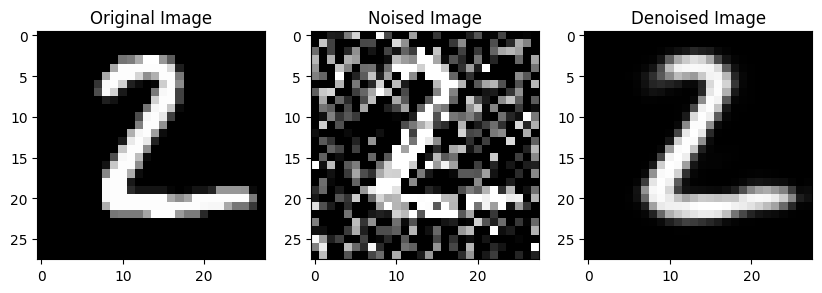

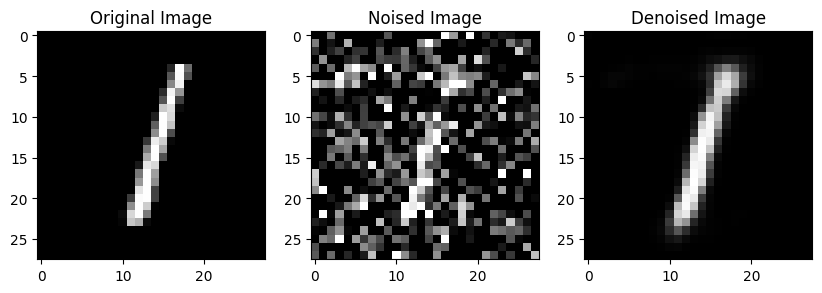

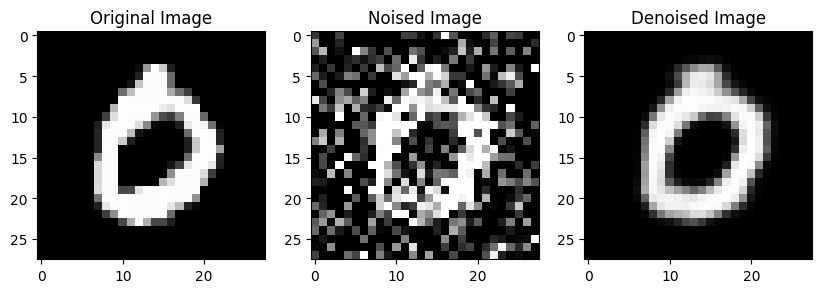

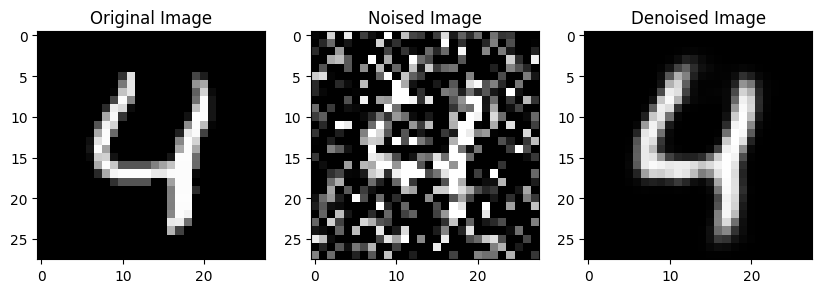

In [14]:
noise_factor = .5
Y_test_50 = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
Y_test_50 = np.clip(Y_test_50, 0., 1.)
denoised_image = model.predict(Y_test_50)
model.evaluate(Y_test_50, X_test)

for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize = (10, 6))
    ax[0].imshow(X_test[i], cmap='gray')
    ax[1].imshow(Y_test_50[i], cmap='gray')
    ax[2].imshow(denoised_image[i], cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].set_title("Noised Image")
    ax[2].set_title("Denoised Image")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


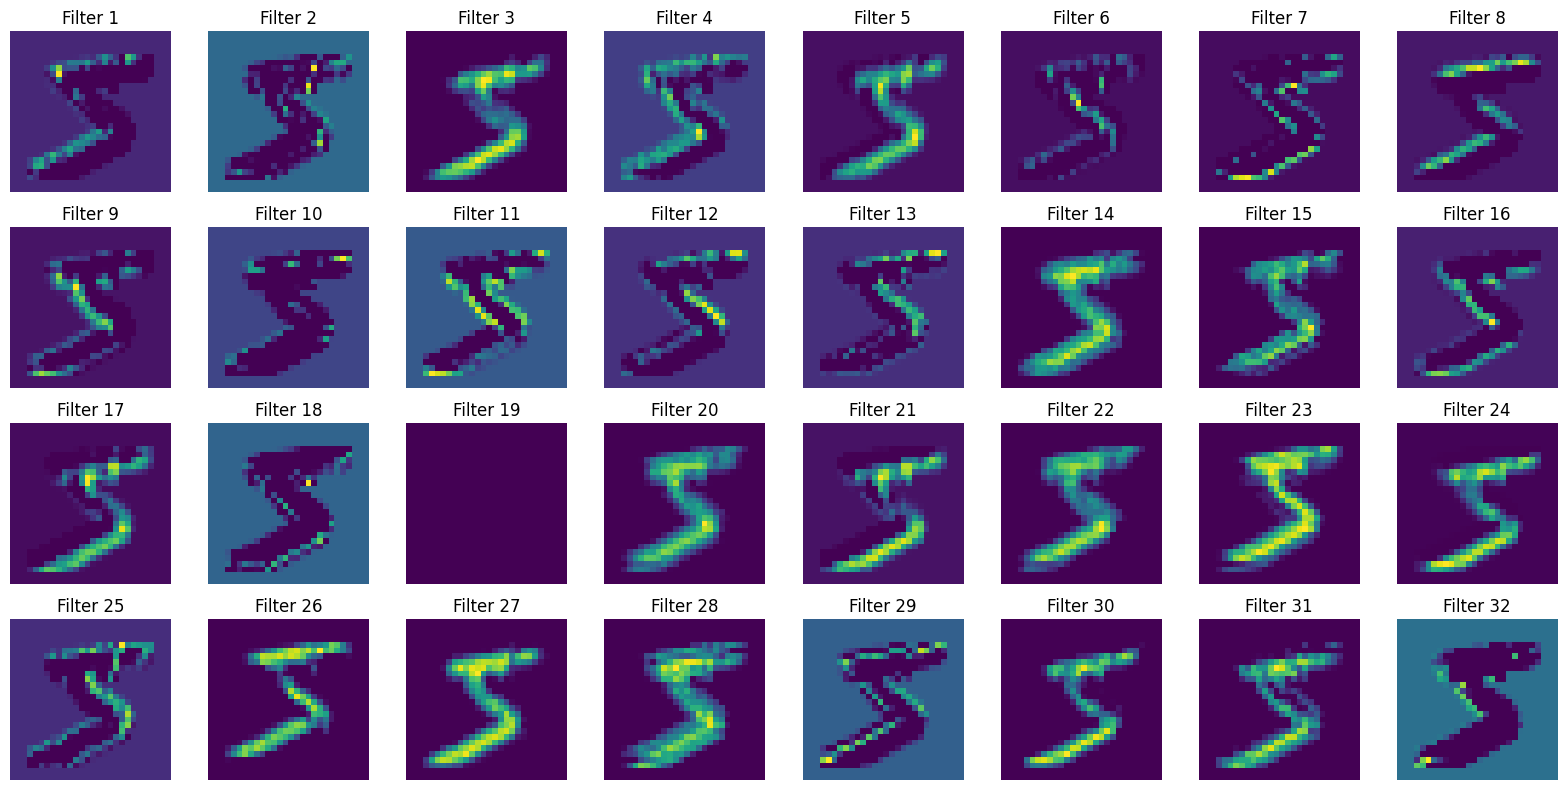

In [23]:
# Visualize the activation maps of conv2d layers (see model.summary()'s output).

# Get the output of the 'conv1' layer
layer_name = 'conv2d' # Name of the first Conv2D layer in the model summary
intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                                 outputs=model.get_layer(layer_name).output)

# Predict the activation map for a sample image
sample_image = X_train[0].reshape(1, 28, 28, 1)
activation_map = intermediate_layer_model.predict(sample_image)

# Display some of the activation maps
num_filters = activation_map.shape[-1]
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        ax.imshow(activation_map[0, :, :, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


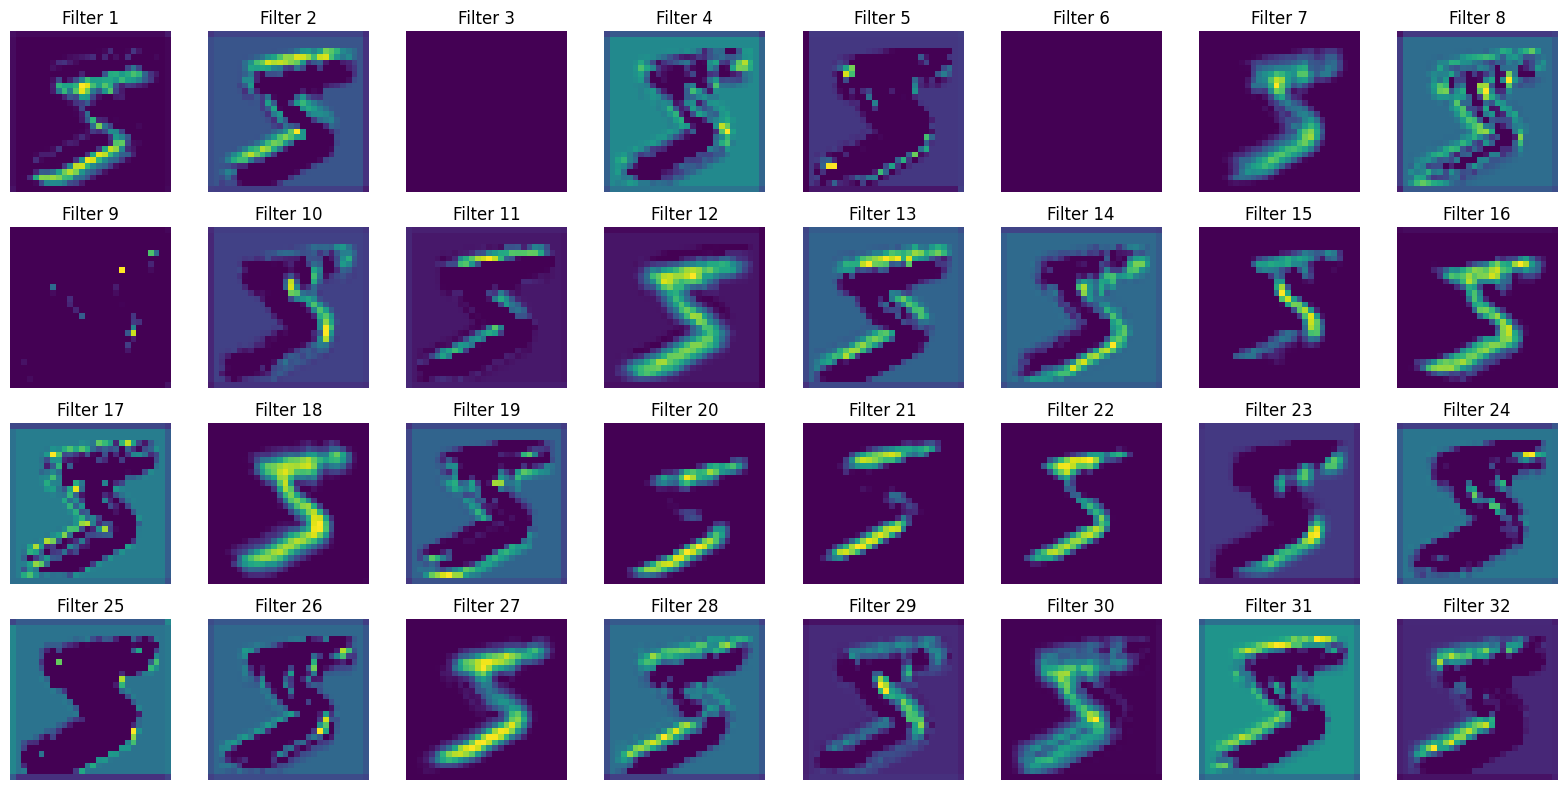

In [24]:
# Visualize the activation map of conv2d_1

layer_name = 'conv2d_1'
intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Predict the activation map for a sample image
sample_image = X_train[0].reshape(1, 28, 28, 1)
activation_map = intermediate_layer_model.predict(sample_image)

# Display some of the activation maps
num_filters = activation_map.shape[-1]
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        ax.imshow(activation_map[0, :, :, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


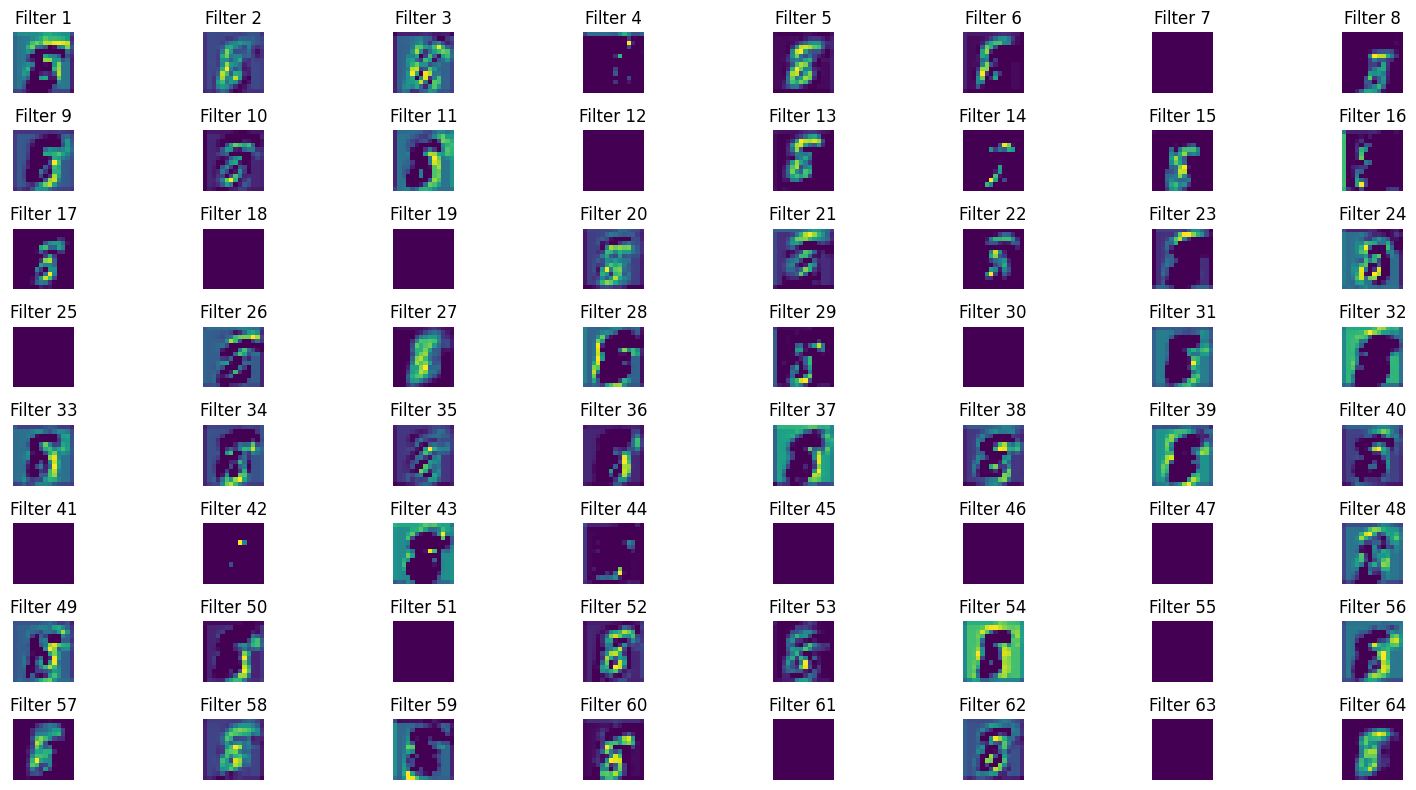

In [26]:
# Visualize the activation map of conv2d_2

# Get the output of the 'conv3' layer
layer_name = 'conv2d_2' # Name of the third Conv2D layer in the model summary
intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                                 outputs=model.get_layer(layer_name).output)

# Predict the activation map for a sample image
sample_image = X_train[n].reshape(1, 28, 28, 1)
activation_map = intermediate_layer_model.predict(sample_image)

# Display some of the activation maps
num_filters = activation_map.shape[-1]
fig, axes = plt.subplots(8, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        ax.imshow(activation_map[0, :, :, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

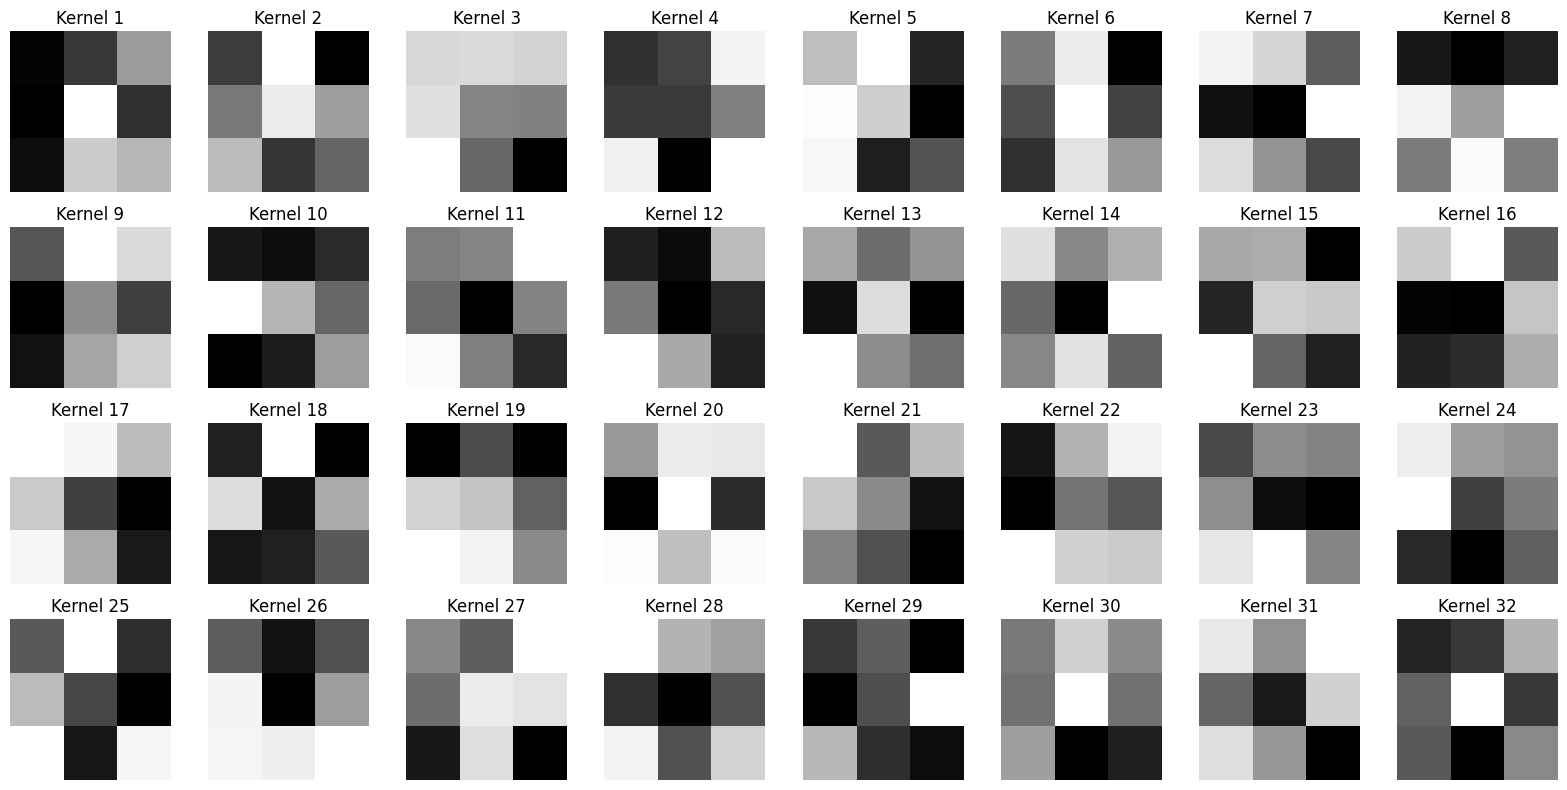

In [27]:
# Visualize the 2D kernels of the first layer

# Get the weights of the first convolutional layer
conv1_layer = model.get_layer('conv2d')
kernels = conv1_layer.get_weights()[0] # Get the kernel weights

# Normalize the kernel values for visualization
min_w, max_w = kernels.min(), kernels.max()
kernels = (kernels - min_w) / (max_w - min_w)

# Display the kernels
num_filters = kernels.shape[-1]
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        # Kernels have shape (height, width, in_channels, out_channels)
        # We are visualizing each output channel's kernel for the single input channel
        ax.imshow(kernels[:, :, 0, i], cmap='gray')
        ax.set_title(f'Kernel {i+1}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()